In [77]:
import numpy as np
import healpy as hp
from scipy import special
from FreqState import FreqState
from save_galaxy_map import write_map
import h5py
import matplotlib.pyplot as plt

np.random.seed(42)

# Create input map

In [60]:
fmax = 1420
fmin = 1419
nfreq = 2

fstate = FreqState()
fstate.freq = (fmax, fmin, nfreq)

ngals = 3

gal_temps = np.random.uniform(size=ngals)
ras = np.random.choice(np.linspace(0,360),size=ngals)
decs = np.random.choice(np.linspace(44.5,45.5),size=ngals)

# to make sure we have consistency
ras_use = np.array([51.42857143, 337.95918367, 249.79591837])
decs_use = np.array([44.76530612, 44.82653061, 45.21428571])

nside = 64
npol = 4

map_ = np.zeros((nfreq, npol, 12* nside**2), dtype=np.float64)
for i in range(nfreq):
    map_[i, 0, hp.ang2pix(nside, ras_use, decs_use, lonlat=True)] += gal_temps

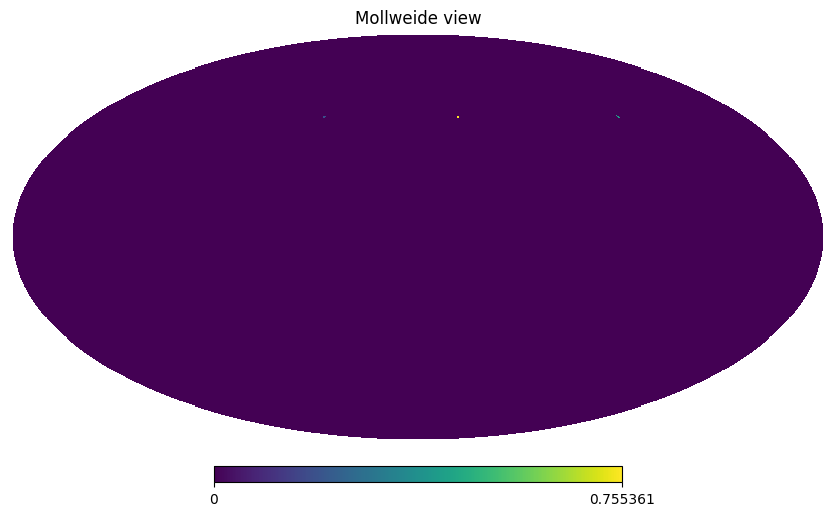

In [61]:
hp.mollview(map_[0,0,:])

In [62]:
write_map('input.h5', map_, fstate.frequencies, fstate.freq_width, include_pol=True)

# Examining the 2D input vs dirty map

In [74]:
f = h5py.File('input.h5')
input_map = np.array(f['map'][:])
f.close()

In [88]:
def map_in_ra_dec(Map, nRA=2048, nDec=2048):
    '''converts a healpix map into RA and Dec coordinates (degrees)
        Takes some time to run.
    
    Inputs
    ------
    Map: ndarray
        One-dimensional array containing one slice of healpix map at one polarization
    nRA: int, 2^n
        number of Ra values to sample, dictates map resolution
    nDec: int, 2^n
        number of Dec values to sample, dictates map resolution
    '''
    lat = 49.320751  # CHORD latitude
    ra = np.linspace(0,360,nRA,endpoint=False)
    el = np.linspace(-0.1,-0.04,nDec,endpoint=False)
    za = np.arcsin(el)
    dec = np.degrees(za) + lat

    # This function will convert the healpix map to RA DEC coordinates
    phi = np.radians(ra)
    theta = np.radians(90-dec)
    nside = hp.npix2nside(Map.shape[0])
    map_ra_dec =  np.zeros((dec.shape[0],ra.shape[0]))
    r = hp.rotator.Rotator(coord=['E','E'])

    print('Converting healpix map into RA, Dec coordinates...')
    for ii,tt in enumerate(theta):
        for jj,pp in enumerate(phi):
            theta_g,phi_g = r(tt,pp)
            n = hp.pixelfunc.ang2pix(nside,theta_g,phi_g)
            map_ra_dec[ii,jj] = Map[n]
    return map_ra_dec, ra, dec

In [132]:
input_2d, ra, dec = map_in_ra_dec(input_map[0,0,:],
                                 nRA=256,
                                 nDec=32)

Converting healpix map into RA, Dec coordinates...


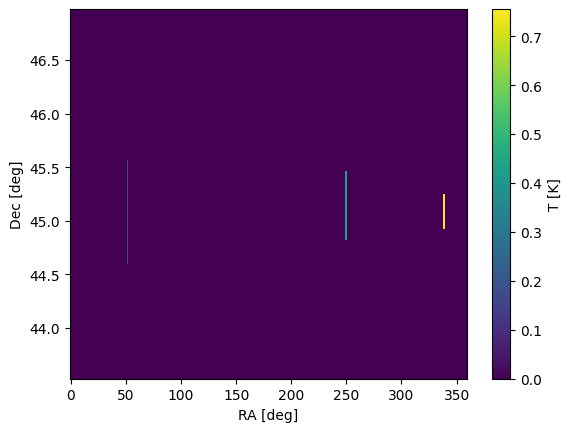

In [133]:
plt.pcolor(ra, dec, input_2d)
plt.ylabel('Dec [deg]')
plt.xlabel('RA [deg]')
plt.colorbar(label='T [K]')
plt.show()

# Examining the 1D input vs dirty map

In [112]:
xlims = (6900,7500)

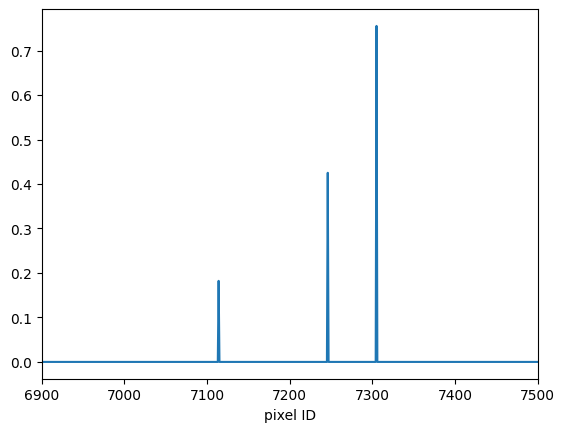

In [113]:
plt.plot(input_map[0,0,:])
plt.xlim(xlims)
plt.xlabel('pixel ID')
plt.show()

# 1D matched filter

In [2]:
class GaussianBeam():

    def __init__(self, npix=10, std=1):
        
        self.std = std
        self.npix = npix

    def get_beam(self):

        x = np.linspace(-(self.npix//2), self.npix//2, self.npix)
        beam = np.exp(-x**2 / (2*self.std**2))

        return beam

        

class AiryBeam():

    def __init__(self, npix=10):
        
        self.npix = npix

    def get_beam(self):

        x = np.linspace(-(self.npix//2), self.npix//2, self.npix)
        beam = special.jv(1, x*2*np.pi)/(2*np.pi*x)

        return beam


BEAMS = {'gaussian': GaussianBeam(),
        'airy': AiryBeam()}


In [7]:
def create_1d_input_map(npix, nsources, source_brightness=None, seed=0):

    np.random.seed(seed)
    map_1d = np.zeros(npix)

    for i, n in enumerate(nsources):
        location = np.choice(npix)

        if source_brightness:
            map_1d[location] = source_brightness[i]
        else:
            map_1d[location] = np.random.uniform()

    return map_1d

def perform_observation(map, telescope_beam=None):
    '''
    Performs a mock observation of a map by convolving with a chosen beam
    
    Inputs:
    -------
    map: 1D array representing the input map
    telescope_beam: string labelling the type of beam.
                    default is None and using hp.smoothing which is Gaussian symmetric.
                    Options are "airy" "gaussian". 
                    
    Outputs:
    --------
    map_observed: 1D array representing the observed map'''
    
    npix = map.size

    if telescope_beam is None:
        map_observed = hp.smoothing(map)
    
    else:
        beam_object = BEAMS[telescope_beam](npix)
        beam = beam_object.get_beam()
        map_observed = np.fft.ifft(np.fft.fft(beam) * np.fft.fft(map))

    return map_observed



def add_noise(map, noise_std, seed=0):

    pass

In [4]:
nside = 32
npix = hp.nside2npix(nside)

In [ ]:
nside = 32

map_1D = np.zeros(12*nside**2)

map_[1000] = 1
map_[10000] = 0.5